In [10]:
# data processing and utils
import pandas as pd
import itertools
from tqdm import tqdm
import numpy as np
from collections import Counter
import re
import csv
from collections import defaultdict

# math and ml
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
import scipy.stats as ss
import math
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import pydot

In [2]:
def trimm_correlated(df_in, threshold):
    df_corr = df_in.corr(method='spearman', min_periods=1)
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    return df_out

In [3]:
# data loading

#tag = 'AP_BX_1'
#tag = 'AP_SR_1'
#tag = 'AP_BX_1,2,3'
#tag = 'AP_SR_1,2,3'
#tag = 'EFS_BX_1'
#tag = 'EFS_SR_1'
#tag = 'EFS_BX_1,2,3'
#tag = 'EFS_SR_1,2,3'
tag = 'AP_BX_7'
#tag = 'EFS_BX_7'

train = pd.read_csv('input_ML/'+tag+'_train.tsv',sep='\t',index_col=0)
test = pd.read_csv('input_ML/'+tag+'_test.tsv',sep='\t',index_col=0)
print(train.shape)
print(test.shape)

if tag.startswith('AP_'):
    y_train = train['Diagnosis_DEF_3cat'] 
    X_train = train.drop(['Diagnosis_DEF_3cat'], axis=1)
    y_test = test['Diagnosis_DEF_3cat']
    X_test = test.drop(['Diagnosis_DEF_3cat'], axis=1)

if tag.startswith('EFS_'):
    y_train = train['EFS'] 
    X_train = train.drop(['EFS'], axis=1)
    y_test = test['EFS']
    X_test = test.drop(['EFS'], axis=1)

(25, 7)
(10, 7)


In [4]:
# save the most correlated variables
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

sc = StandardScaler()
scaler = StandardScaler()
scaler.fit(X) 
X_scaled = scaler.transform(X) # scale the data
X_scaled = pd.DataFrame(data=X_scaled, index=X.index, columns=X.columns)
df_corr = X_scaled.corr(method='spearman', min_periods=1)

lst = []
for i in df_corr.index:
    lst.append(df_corr[i][df_corr[i].abs()>0.8].index)

with open('output_ML/'+tag+'_corrBiomarks.txt', "w") as f:
    wr = csv.writer(f)
    wr.writerows(lst)

## 1. Feature selection with cross-validation

In [5]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

sc = StandardScaler()
scaler = StandardScaler()
scaler.fit(X) 
X_scaled = scaler.transform(X) # scale the data
X_scaled = pd.DataFrame(data=X_scaled, index=X.index, columns=X.columns)
X_scaled = trimm_correlated(X_scaled,0.8) # remove variables >0.8 correlation

lst = []
for c in tqdm([i/100 for i in range(11)][1:]):
    svc = SVC(kernel="linear", C=c, class_weight='balanced')
    min_features_to_select = 5  # Minimum number of features to consider
    rfecv = RFECV(
        estimator=svc,
        step=1,
        cv=LeaveOneOut(),
        scoring="accuracy",
        min_features_to_select=min_features_to_select,
    )
    rfecv.fit(X_scaled, y)
    
    for k,i in enumerate(range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select)):
        if rfecv.n_features_ == i:
            lst.append([c,rfecv.n_features_,rfecv.grid_scores_[k]])

res = pd.DataFrame.from_records(lst)
res.columns = ['C','opt num of features','accuracy']

100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


      C  opt num of features  accuracy
0  0.01                    2  0.742857
1  0.02                    4  0.742857
2  0.03                    4  0.771429
3  0.04                    3  0.742857
4  0.05                    3  0.742857
5  0.06                    2  0.742857
6  0.07                    2  0.742857
7  0.08                    2  0.742857
8  0.09                    2  0.742857
9  0.10                    2  0.742857


best C: [0.03]


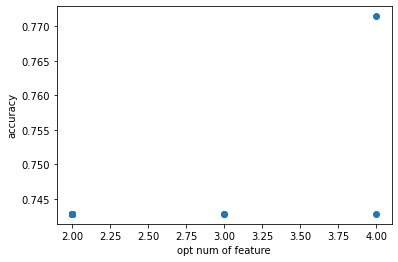

In [6]:
res.to_csv('output_ML/'+tag+'_CparamOpt.tsv',sep='\t',index=None)
print(res)
print('\n')

best_c = res.sort_values(['accuracy','opt num of features'], ascending=[False, True]).head(1)['C'] # highest accuracy and lower num of features
print('best C:',best_c.ravel())
plt.scatter(res['opt num of features'],res['accuracy'])
plt.xlabel('opt num of feature')
plt.ylabel('accuracy')
plt.savefig('output_ML/'+tag+'_CparamOpt.png', bbox_inches='tight')

Index(['DLK_5', 'DKK1', 'DLK_1', 'DLK'], dtype='object')


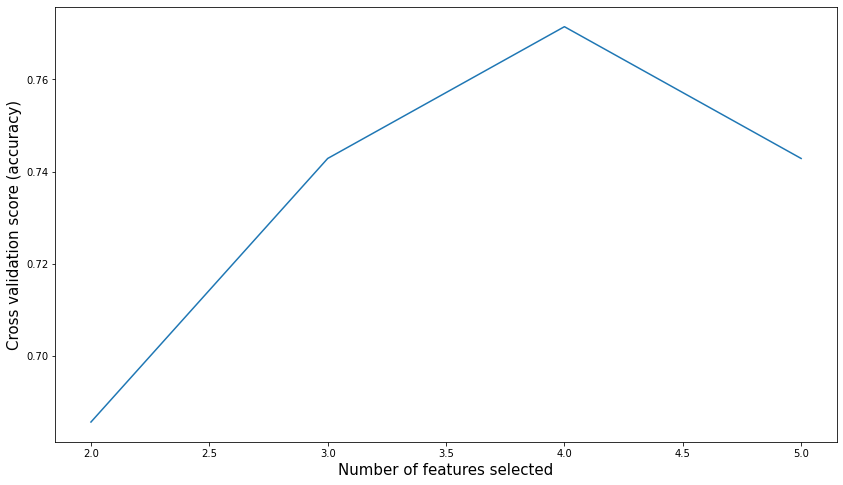

In [7]:
c=best_c
svc = SVC(kernel="linear", C=c, class_weight='balanced')
min_features_to_select = 5  # Minimum number of features to consider
rfecv = RFECV(
        estimator=svc,
        step=1,
        cv=LeaveOneOut(),
        scoring="accuracy",
        min_features_to_select=min_features_to_select)
rfecv.fit(X_scaled, y)

plt.figure(figsize=(14,8))
plt.xlabel("Number of features selected", fontsize=15)
plt.ylabel("Cross validation score (accuracy)", fontsize=15)
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.savefig('output_ML/'+tag+'_RFECV.png', bbox_inches='tight')

print(X_scaled.columns[rfecv.ranking_ == 1])
textfile = open('output_ML/'+tag+'_RFECV_bestFeatures.txt', "w")
for element in X_scaled.columns[rfecv.ranking_ == 1]:
    textfile.write(element + "\n")
textfile.close()

## 2. Supervised classification

Train accuracy: 0.68
Test accuracy: 0.5


/home/dcirillo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dcirillo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dcirillo/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


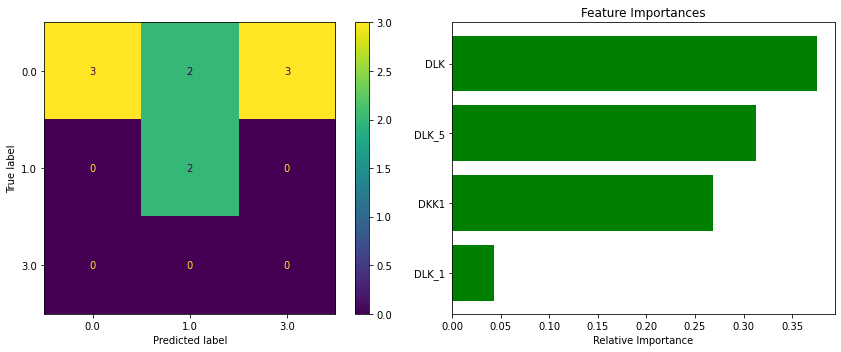

In [8]:
features = X_scaled.columns[rfecv.ranking_ == 1]

classifier = BalancedRandomForestClassifier(max_depth=5, random_state=0, class_weight="balanced_subsample")

classifier.fit(X_train[features], y_train)
y_pred = classifier.predict(X_train[features])
print('Train accuracy: ' + str(accuracy_score(y_train, y_pred)))
y_pred = classifier.predict(X_test[features])
print('Test accuracy: ' + str(accuracy_score(y_test, y_pred)))


report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report)
report_df.to_csv('output_ML/'+tag+'_RF_report.tsv',sep='\t') 

cm = confusion_matrix(y_test, y_pred)

features = features
importances = classifier.feature_importances_
indices = np.argsort(importances)

# plots

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax1 = plt.subplot(axes[0])
plot_confusion_matrix(classifier, X_test[features], y_test, ax=ax1)
ax1.grid(False)
axes[1].barh(range(len(indices)), importances[indices], color='g', align='center')
axes[1].set_yticks(range(len(indices)))
axes[1].set_yticklabels([features[i] for i in indices])
axes[1].set_xlabel('Relative Importance')
if len(features)>=10:
    axes[1].set_ylim([max(indices)-10, max(indices)])
    axes[1].set_title('Feature Importances (top 10)')
else:
    axes[1].set_title('Feature Importances')
fig.tight_layout()
plt.savefig('output_ML/'+tag+'_RF.png', bbox_inches='tight')

In [9]:
df_import = [[features[indices[i]],importances[i]] for i in range(len(indices))]
df_import = pd.DataFrame.from_records(df_import)
df_import.columns = ['feature','RF_importance']
df_import = df_import.sort_values('RF_importance', ascending=False)
df_import.to_csv('output_ML/'+tag+'_RF_importance.tsv',sep='\t',index=False)
df_import

,feature,RF_importance
3,DLK,0.37500
0,DLK_1,0.31250
1,DKK1,0.26875
2,DLK_5,0.04375
